In [58]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import * 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from urllib.request import urlretrieve
from owslib.wfs import WebFeatureService
from dotenv import load_dotenv
from pyspark.sql import functions as F

# Create a spark session
spark = (
    SparkSession.builder.appName("analysis")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "2g")
    .config("spark.executor.memory", "6g")
    .getOrCreate()
)

## Population Data 

In [59]:
pop_sdf = spark.read.parquet("../data/curated/pop_sdf.parquet/")
pop_sdf.limit(5)

State/Terr,SA2 code,SA2 name,Total,Under 10,Adolescent,Young adult,Middle age,Old
New South Wales,115011556,Castle Hill - South,10436,1256,1454,1704,3718,2304
New South Wales,115011557,Castle Hill - West,5198,568,849,810,1928,1043
New South Wales,115011558,Cherrybrook,19135,1982,3084,2522,6760,4787
New South Wales,115011621,Kellyville - East,17748,2300,3032,2748,6701,2967
New South Wales,115011622,Kellyville - West,11417,1702,1453,2162,4067,2033


Get sum of each age group and create pie charts for each state and territory.

In [60]:
pop_agg_st = pop_sdf.groupBy("State/Terr") \
    .sum("Under 10", "Adolescent", "Young adult", "Middle age", "Old")

pop_agg_st_df = pop_agg_st.toPandas()

In [61]:
pop_agg_st_df.set_index("State/Terr", inplace=True)

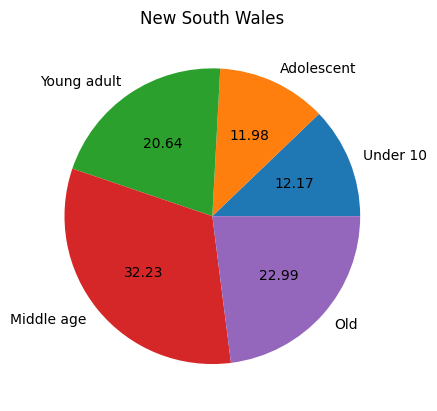

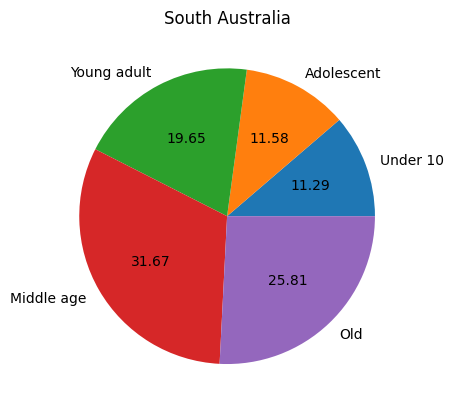

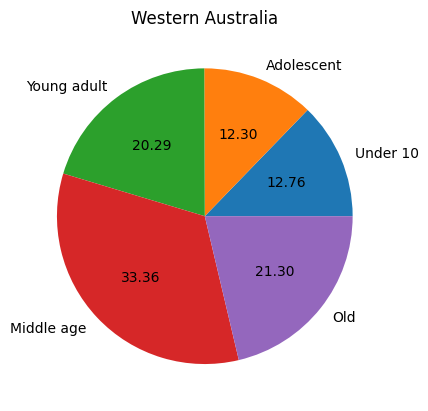

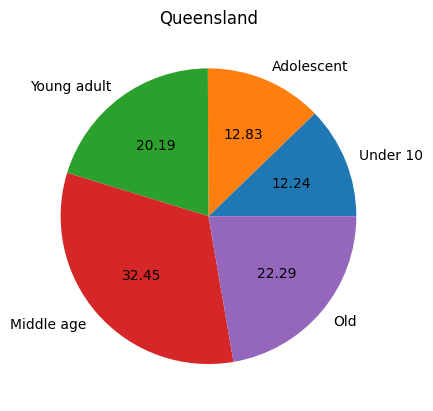

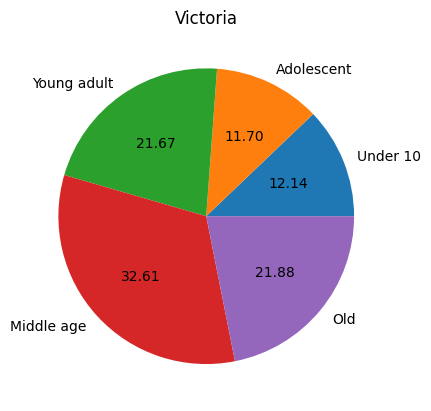

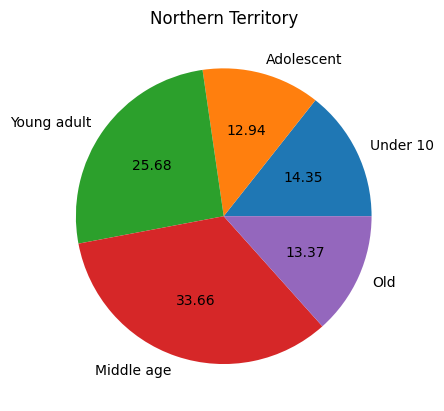

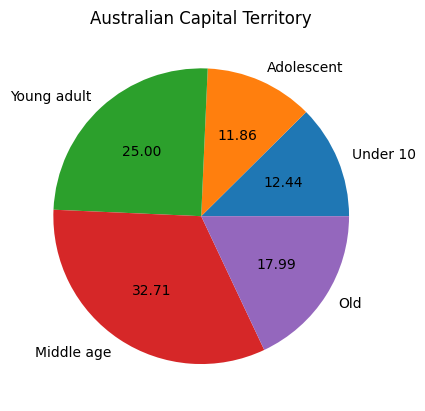

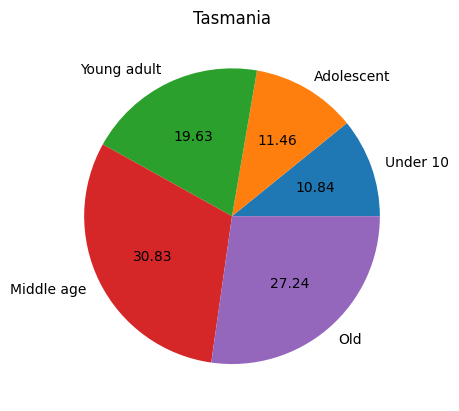

In [62]:
from matplotlib import pyplot as plt

states = list(pop_agg_st_df.index)

groups = {
    'Under 10': [0, 10],
    'Adolescent': [10, 20],
    'Young adult': [20, 35],
    'Middle age': [35, 60],
    'Old': [60, 86]
}

i = 0
for state in states:
    data = list(pop_agg_st_df.loc[state])

    plt.figure(i)
    plt.title(state)
    plt.pie(data, autopct='%.2f', labels=list(groups.keys()))
    
    i += 1

plt.show()

The distribution of the age groups for the states and territories are extremely similar, with middle age population being the most abundant (understandable as it has the largest age range from the other groups) for all states. Then we have the old population followed by young adults, with the exception of ACT and NT where instead, there is a larger population of young adults than old people.

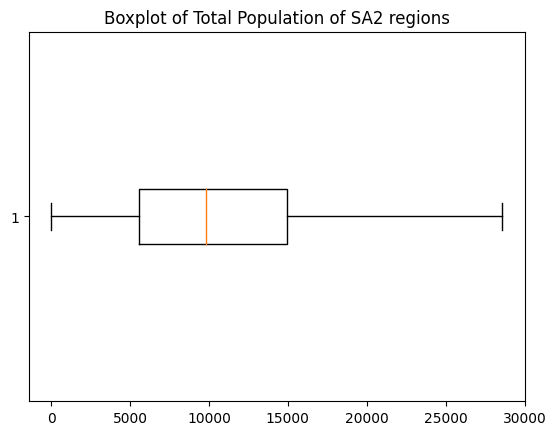

In [65]:
pop_df = pop_sdf.toPandas()
plt.boxplot(pop_df["Total"], vert=0)
plt.title("Boxplot of Total Population of SA2 regions")
plt.show()

Surprisingly, there seem to be no outliers present in the data. As the data has been previously preprocessed, this means that there is not much natural variation in the total population.

Examine regions with the lowest total population:

In [9]:
pop_sdf.sort(asc("Total"))

State/Terr,SA2 code,SA2 name,Total,Under 10,Adolescent,Young adult,Middle age,Old
Queensland,308051537,South Trees,0,0,0,0,0,0
Tasmania,601041025,Mount Wellington,0,0,0,0,0,0
Northern Territory,701011003,East Point,0,0,0,0,0,0
Australian Capita...,801051128,Russell,0,0,0,0,0,0
Australian Capita...,801071085,Mount Taylor,0,0,0,0,0,0
Australian Capita...,801061066,Lake Burley Griffin,0,0,0,0,0,0
Northern Territory,701021014,Buffalo Creek,0,0,0,0,0,0
Australian Capita...,801081133,Scrivener,0,0,0,0,0,0
Australian Capita...,801041117,Gungahlin - West,0,0,0,0,0,0
Australian Capita...,801011142,Macnamara,0,0,0,0,0,0


Can observe that the SA2 regions having total population zero are places such as airports, creeks and other 'green' uninhabitable places. <br>
Will not remove these regions as they might prove useful in further analysis.

In [13]:
pop_sdf.where(pop_sdf.Total == 0).count()

38

There are a total of 38 SA2 regions with 0 population

In [71]:
pop_sdf.where(pop_sdf.Total < 500).sort(desc("Total"))

State/Terr,SA2 code,SA2 name,Total,Under 10,Adolescent,Young adult,Middle age,Old
New South Wales,108031161,Lord Howe Island,444,55,21,83,156,129
Australian Capita...,801031031,Hume,394,0,9,198,165,22
Queensland,313051574,Moreton Island,314,0,25,112,107,70
Australian Capita...,801041043,Hall,299,16,60,17,112,94
Australian Capita...,801031115,Majura,297,20,36,139,68,34
Victoria,204011061,Upper Yarra Valley,240,27,39,23,119,32
Western Australia,505021091,Osborne Park Indu...,229,0,0,179,38,12
South Australia,406011135,Western,144,10,4,44,69,17
Victoria,205031088,French Island,138,8,18,0,58,54
Queensland,302031036,Brisbane Airport,131,0,0,68,58,5


Examine regions with the highest total population:

In [14]:
pop_sdf.sort(desc("Total"))

State/Terr,SA2 code,SA2 name,Total,Under 10,Adolescent,Young adult,Middle age,Old
Victoria,213051583,Tarneit - Central,28573,5698,4045,7134,9716,1980
Victoria,212011552,Pakenham - South ...,27169,4700,3976,5911,8731,3851
Western Australia,507051313,Baldivis - South,27024,4929,4317,5739,8906,3133
South Australia,404031107,Plympton,26871,2723,2489,7652,8073,5934
Victoria,205031093,Wonthaggi - Inver...,26723,2652,2696,3439,7889,10047
South Australia,402031036,Enfield - Blair A...,26031,3344,2708,7448,8021,4510
New South Wales,116011307,Lalor Park - King...,25565,3460,3095,4887,8689,5434
Western Australia,504011045,Bayswater - Emble...,25418,3118,2552,5289,9058,5401
New South Wales,119031374,South Hurstville ...,25399,2508,2788,6466,7937,5700
Western Australia,506041133,Canning Vale - East,25397,3474,3467,5334,9368,3754


Examine regions with the highest population of young adults and middle age adults:

In [74]:
pop_sdf.sort(desc("Young adult"))

State/Terr,SA2 code,SA2 name,Total,Under 10,Adolescent,Young adult,Middle age,Old
Victoria,206041504,Melbourne CBD - N...,17439,366,1170,12585,2804,514
New South Wales,117031645,Sydney (South) - ...,20346,799,722,11537,5936,1352
Victoria,206041505,Melbourne CBD - West,16179,443,641,10809,3622,664
New South Wales,117011635,Mascot,21819,1942,1350,10493,5778,2256
Victoria,206041117,Carlton,17198,651,1469,9931,3375,1772
Victoria,206041509,Southbank - East,16538,715,562,9573,4549,1139
New South Wales,125011710,Wentworth Point -...,20653,2403,780,9528,6526,1416
New South Wales,120031396,Homebush,21023,2432,1436,9150,6079,1926
South Australia,401011001,Adelaide,18639,681,1234,8921,4923,2880
Queensland,305031128,Newstead - Bowen ...,18463,813,640,8797,5888,2325


Can observe that cities and places close to cities have the highest population of young adults

In [75]:
pop_sdf.sort(desc("Middle age"))

State/Terr,SA2 code,SA2 name,Total,Under 10,Adolescent,Young adult,Middle age,Old
Victoria,213051583,Tarneit - Central,28573,5698,4045,7134,9716,1980
Western Australia,506041133,Canning Vale - East,25397,3474,3467,5334,9368,3754
New South Wales,115011290,Baulkham Hills - ...,24853,3731,3122,3752,9183,5065
Victoria,208021174,Bentleigh - McKinnon,25201,2843,3602,4452,9134,5170
Western Australia,504011045,Bayswater - Emble...,25418,3118,2552,5289,9058,5401
New South Wales,116021632,Schofields - East,25314,5152,3250,6476,8984,1452
New South Wales,116021563,Quakers Hill,24870,4055,3243,5319,8930,3323
Queensland,314011386,The Hills District,24782,3285,3386,4521,8927,4663
Western Australia,507051313,Baldivis - South,27024,4929,4317,5739,8906,3133
Victoria,212011552,Pakenham - South ...,27169,4700,3976,5911,8731,3851


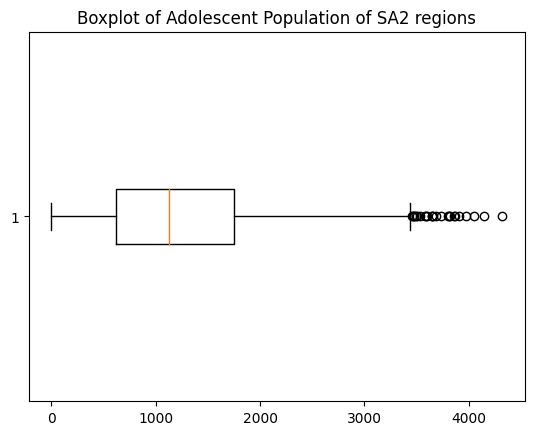

In [76]:
plt.boxplot(pop_df["Adolescent"], vert=0)
plt.title("Boxplot of Adolescent Population of SA2 regions")
plt.show()

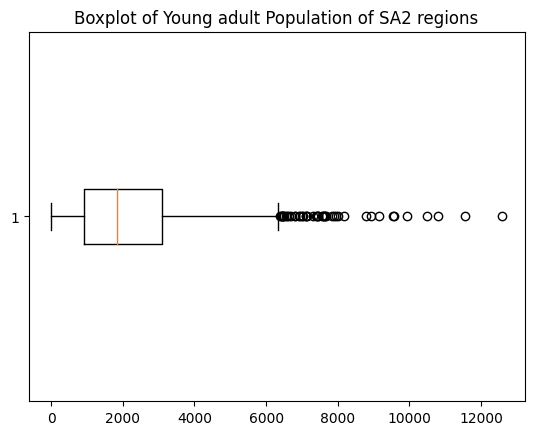

In [77]:
plt.boxplot(pop_df["Young adult"], vert=0)
plt.title("Boxplot of Young adult Population of SA2 regions")
plt.show()

Get relative percentages for each age group:

In [78]:
drop_cols = ['Under 10', 'Adolescent', 'Young adult', 'Middle age', 'Old']

pop_percents_sdf = pop_sdf.withColumns({
    '%Under 10': F.round((pop_sdf['Under 10'] / pop_sdf.Total)*100, 2),
    '%Adolescent': F.round((pop_sdf.Adolescent / pop_sdf.Total)*100, 2),
    '%Young adult': F.round((pop_sdf['Young adult'] / pop_sdf.Total)*100, 2),
    '%Middle age': F.round((pop_sdf['Middle age'] / pop_sdf.Total)*100, 2),
    '%Old': F.round((pop_sdf.Old / pop_sdf.Total)*100, 2)
}).drop(*drop_cols)

In [79]:
print(pop_percents_sdf.count())
pop_percents_sdf.limit(5)

2450


State/Terr,SA2 code,SA2 name,Total,%Under 10,%Adolescent,%Young adult,%Middle age,%Old
New South Wales,115011556,Castle Hill - South,10436,12.04,13.93,16.33,35.63,22.08
New South Wales,115011557,Castle Hill - West,5198,10.93,16.33,15.58,37.09,20.07
New South Wales,115011558,Cherrybrook,19135,10.36,16.12,13.18,35.33,25.02
New South Wales,115011621,Kellyville - East,17748,12.96,17.08,15.48,37.76,16.72
New South Wales,115011622,Kellyville - West,11417,14.91,12.73,18.94,35.62,17.81


In [80]:
pop_percents_sdf.where(pop_percents_sdf.Total == 0).count()

38

In [81]:
pop_perc_cols = ["%Under 10", "%Adolescent", "%Young adult", "%Middle age", "%Old"]
for perc_col in pop_perc_cols:
    print(pop_percents_sdf.agg(min(perc_col), max(perc_col)))

+--------------+--------------+
|min(%Under 10)|max(%Under 10)|
+--------------+--------------+
|           0.0|          40.0|
+--------------+--------------+

+----------------+----------------+
|min(%Adolescent)|max(%Adolescent)|
+----------------+----------------+
|             0.0|           53.15|
+----------------+----------------+

+-----------------+-----------------+
|min(%Young adult)|max(%Young adult)|
+-----------------+-----------------+
|              0.0|            100.0|
+-----------------+-----------------+

+----------------+----------------+
|min(%Middle age)|max(%Middle age)|
+----------------+----------------+
|             0.0|           100.0|
+----------------+----------------+

+---------+---------+
|min(%Old)|max(%Old)|
+---------+---------+
|      0.0|    100.0|
+---------+---------+



There appear to be regions that are populated completely by either young adults, middle aged adults, or old people

In [82]:
print(pop_percents_sdf.where(pop_percents_sdf["%Young adult"] == 100.0).count())
print(pop_percents_sdf.where(pop_percents_sdf["%Middle age"] == 100.0).count())
print(pop_percents_sdf.where(pop_percents_sdf["%Old"] == 100.0).count())

1
3
5


In [83]:
pop_percents_sdf.where(pop_percents_sdf["%Young adult"] == 100.0).show()
pop_percents_sdf.where(pop_percents_sdf["%Middle age"] == 100.0).show()
pop_percents_sdf.where(pop_percents_sdf["%Old"] == 100.0).show()

+---------------+---------+--------------------+-----+---------+-----------+------------+-----------+----+
|     State/Terr| SA2 code|            SA2 name|Total|%Under 10|%Adolescent|%Young adult|%Middle age|%Old|
+---------------+---------+--------------------+-----+---------+-----------+------------+-----------+----+
|New South Wales|123021439|Holsworthy Milita...|    3|      0.0|        0.0|       100.0|        0.0| 0.0|
+---------------+---------+--------------------+-----+---------+-----------+------------+-----------+----+

+--------------------+---------+-----------------+-----+---------+-----------+------------+-----------+----+
|          State/Terr| SA2 code|         SA2 name|Total|%Under 10|%Adolescent|%Young adult|%Middle age|%Old|
+--------------------+---------+-----------------+-----+---------+-----------+------------+-----------+----+
|   Western Australia|506011111|Ashendon - Lesley|    3|      0.0|        0.0|         0.0|      100.0| 0.0|
|   Western Australia|507021

As the total population of these regions is less than or equal to 10, it is understandable that these places may be fully inhabited by a single age group.